In [1]:
import numpy as np
from datasets import load_dataset
from pyannote.database import registry

from pyannote.audio import Model
from pyannote.audio.tasks import SpeakerDiarization

registry.load_database(
    "/home/kamil/projects/AMI-diarization-setup/pyannote/database.yml"
)
ami = registry.get_protocol("AMI.SpeakerDiarization.only_words")

seg_task = SpeakerDiarization(
    ami, duration=10.0, max_speakers_per_chunk=3, max_speakers_per_frame=2
)
pretrained = Model.from_pretrained("pyannote/segmentation-3.0", use_auth_token=True)
seg_task.model = pretrained

synthetic_ami_dataset = load_dataset("kamilakesbi/ami_spd_nobatch")

synthetic_ami_dataset_processed = load_dataset(
    "kamilakesbi/ami_spd_nobatch_processed_sc"
)

def get_chunk_from_pyannote(protocol, segmentation_task, file_id, start_time, duration):

    seg_task.prepare_data()
    seg_task.setup()

    chunk = seg_task.prepare_chunk(file_id, start_time, duration)

    return chunk

# Extract 10 second audio from meeting EN2001a (= file_id 124).
# We choose start_time = 3.34 to match with the first 10 seconds of audio of the synthetic AMI.
real_ami_chunk = get_chunk_from_pyannote(ami, seg_task, 124, 3.34, 10)

synthetic_ami_chunk = synthetic_ami_dataset_processed["train"][0]

real_labels = real_ami_chunk["y"].data
synthetic_labels = np.array(synthetic_ami_chunk["labels"])

/home/kamil/projects/pyannote-audio/env/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/home/kamil/projects/pyannote-audio/pyannote/audio/core/io.py:43: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


'AMI-SDM.SpeakerDiarization.only_words' found in /home/kamil/projects/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI-SDM.SpeakerDiarization.mini' found in /home/kamil/projects/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.only_words' found in /home/kamil/projects/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.mini' found in /home/kamil/projects/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.word_and_vocalsounds' found in /home/kamil/projects/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, dat

In [2]:
from IPython.display import Audio
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
waveform_real = np.array(real_ami_chunk['X'][0]) 
audio = Audio(waveform_real, rate=16000)

with open('real.wav', 'wb') as f:
    f.write(audio.data)

In [4]:
waveform_synthetic = np.array(synthetic_ami_chunk['waveforms'])
audio = Audio(waveform_synthetic, rate=16000)

with open('synthetic.wav', 'wb') as f:
    f.write(audio.data)

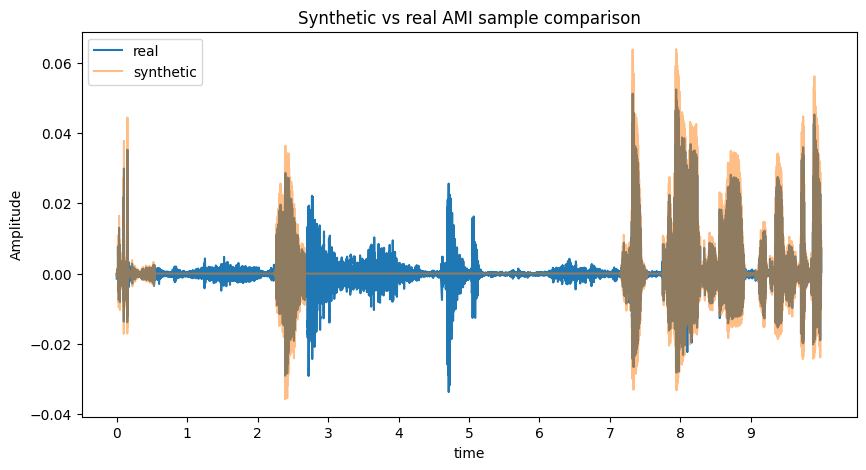

In [5]:
plt.figure(figsize = (10,5))
plt.plot(waveform_real, label = 'real')
plt.plot(waveform_synthetic, label = 'synthetic', alpha=0.5)
plt.xlabel('time')
plt.xticks(range(1,160000, 16000),  labels=[i for i in range(0,10)])
plt.ylabel('Amplitude')
plt.title('Synthetic vs real AMI sample comparison')
plt.legend()
plt.savefig('real vs synthetic - comparison')

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

index_positions = np.nonzero(waveform_synthetic)

synthetic_audio = waveform_synthetic[index_positions]
real_audio = waveform_real[index_positions]

similarity_without_zeros = cosine_similarity([synthetic_audio], [real_audio])
similarity_with_zeros = cosine_similarity([waveform_synthetic], [waveform_real])

print(similarity_without_zeros)
print(similarity_with_zeros)

[[0.96529163]]
[[0.88117158]]
